In [1]:
import reviews_soli

car_to_reviews, car_to_result_stats = \
    reviews_soli.simulate_reviews_soli('datasets/edmunds_reviews.csv')

# car: 211
Honda-Odyssey-2011 has 72 reviews


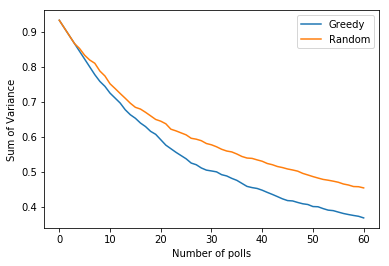


Final ratings:
Using greedy pick:
[valueRating: [1, 0, 0, 3, 4], safetyRating: [0, 0, 1, 1, 2], reliabilityRating: [1, 0, 2, 3, 6], technologyRating: [0, 0, 1, 0, 2], performanceRating: [0, 0, 2, 2, 11], comfortRating: [0, 0, 0, 6, 3], interiorRating: [0, 0, 0, 4, 5]]
Using random pick:
[valueRating: [1, 0, 1, 2, 6], safetyRating: [0, 0, 0, 0, 0], reliabilityRating: [3, 0, 1, 1, 10], technologyRating: [0, 0, 0, 0, 0], performanceRating: [1, 1, 0, 1, 9], comfortRating: [0, 0, 1, 3, 6], interiorRating: [0, 3, 0, 3, 7]]


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import random

print('# car: {}'.format(len(car_to_reviews)))
car = random.choice(list(car_to_reviews.keys()))
reviews = car_to_reviews[car]
print('{} has {} reviews'.format(car, len(reviews)))

greedy_stats, random_stats = car_to_result_stats[car]
X = list(greedy_stats.step_to_cost.keys())
greedy_Y = list(greedy_stats.step_to_cost.values())
random_Y = list(random_stats.step_to_cost.values())

fig, ax = plt.subplots()
line1, = ax.plot(X, greedy_Y, label='Greedy')
line2, = ax.plot(X, random_Y, label='Random')

ax.legend(loc='upper right')
ax.set_xlabel('Number of polls')
ax.set_ylabel('Sum of Variance')
plt.show()

print('\nFinal ratings:')
print('Using greedy pick:\n{}'.format(greedy_stats.final_features))
print('Using random pick:\n{}'.format(random_stats.final_features))